# Cat image classification with 4 layers Neural network with Logistic Regression Relu activation function 


### Import important libraries

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage


%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)



### Function for loading dataset

In [2]:
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_xo = np.array(train_dataset["train_set_x"][:]) 
    train_set_y = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_xo = np.array(test_dataset["test_set_x"][:]) 
    test_set_y = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    
    return train_set_xo, train_set_y, test_set_xo, test_set_y, classes

### Load Dataset

In [3]:
train_xo, train_y, test_xo, test_y, classes = load_data()

### Check index and class

y = 0. It's a non-cat picture.


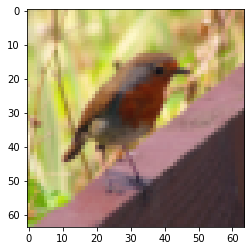

In [4]:
index = 10
plt.imshow(train_xo[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [5]:
test_xo.shape

(50, 64, 64, 3)

### Information about our dataset

In [6]:
m_train = train_xo.shape[0]
num_px = train_xo.shape[1]
m_test = test_xo.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples : " + str(m_test))
print ("Each image is of size: ( "+ str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x shape: " + str(train_xo.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape : " + str(test_xo.shape))
print ("test_y shape : " + str(test_y.shape))

Number of training examples: 209
Number of testing examples : 50
Each image is of size: ( 64, 64, 3)
train_x shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x shape : (50, 64, 64, 3)
test_y shape : (1, 50)


### Flatten the dimensions and standardize them 

In [7]:

train_x_flatten = train_xo.reshape(train_xo.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_xo.reshape(test_xo.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


### Sigmoid Function and its derivative

In [8]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    
    return dZ

### Relu Function and its derivative

In [9]:
def relu(Z):
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ



### Initialization of parameters

In [10]:
def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)           

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        #print((parameters['W' + str(l)]).shape)
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [11]:
#initialize_parameters_deep([12288, 20, 7, 5, 1])


## Model for forward propagation

### Function for linear computaion

In [12]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

### Function for computing Activation

In [13]:
def linear_activation_forward(A_prev, W, b, activation):
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

### Function for forward model

In [14]:
def L_model_forward(X, parameters):
   
    caches = []
    A = X
    L = len(parameters)//2 
    #print("Number of layers:"+str(L))
    for l in range(1, L):
        A_prev = A
        #print(A.shape)
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             activation='relu')
        caches.append(cache)
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          activation='sigmoid')
    caches.append(cache)
   # print(caches)
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

### Function for computing cost

In [15]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
    cost = np.squeeze(cost) 
    #print(cost.shape)
    assert(cost.shape == ())
    return cost

## Model for backward propagation

### Function for linear computaion

In [16]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    #dW =(1. /m)*np.dot(dZ, cache[0].T)
    dW =(1. /m)*np.dot(dZ, A_prev.T)
    db =(1. /m)*(np.sum(dZ, axis=1, keepdims=True))
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

### Function for computing Activation

In [17]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":

        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
    
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    
    return dA_prev, dW, db

### Function for Backward propagation model

In [18]:
def L_model_backward(AL, Y, caches):
  
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] =  linear_activation_backward(dAL,current_cache, activation= "sigmoid")
    for l in reversed(range(L-1)): 
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward( grads["dA" + str(l + 2)],current_cache, activation="relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameter

In [19]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters

In [20]:
layers_dims = [12288, 20, 7, 5, 1]

In [21]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 3000, print_cost=False):
   
    np.random.seed(1)
    costs = []             
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
       
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters, costs




Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747


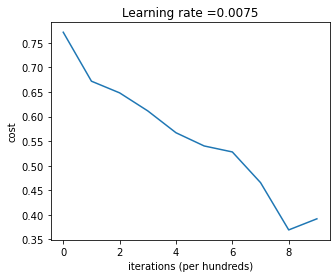

In [22]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims,  learning_rate = 0.0075,num_iterations = 1000, print_cost = True)

### Function Prediction 

In [23]:
def predict(X,y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m))

    Y, caches = L_model_forward(X, parameters)
    
    for i in range(0, Y.shape[1]):
        if Y[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    return Y

In [24]:
p_train = predict(train_x, train_y, parameters)
p_test = predict(test_x, test_y,  parameters).astype(int)

In [25]:
print("train accuracy: {} %".format(100 - np.mean(np.abs(p_train - train_y)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(p_test - test_y)) * 100))

train accuracy: 74.36116438980218 %
test accuracy: 34.0 %


### Test this model with test data

y = [1], it's a 'non-cat' picture.


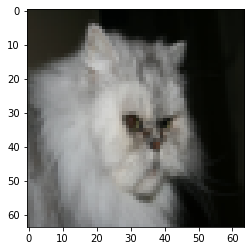

In [26]:
index = 10
plt.imshow(test_xo[index])
print ("y = " + str(test_y[:, index]) + ", it's a '" + classes[np.squeeze(p_test[:, index])].decode("utf-8") +  "' picture.")

### Test the model with the image taken from internet

original size :  (2720, 4106, 3)
new size:  (64, 64, 3)
y = 0.5472741068959106, your L-layer model predicts a "non-cat" picture.


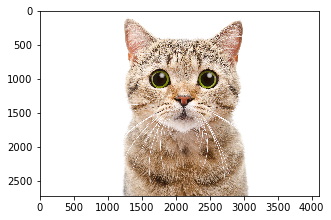

In [27]:
from skimage.transform import  resize
import imageio
a = "images/67586673.jpg"
#imageio.imsave('face.png', face) # First we need to create the PNG file

a= imageio.imread(a)
image = np.array(a)

print("original size : ",image.shape)
my_image=resize(image, (64, 64))
my_label_y = [1] 
print("new size: ", my_image.shape)
my_image = my_image.reshape((my_image.shape[0]*my_image.shape[1]*3,1))
my_image.shape
#my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters) 
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")
plt.imshow(image)
